In [7]:
import sys
# adding signal_handling to the system path
sys.path.insert(0, '../signal_handling/')
sys.path.insert(0, '../nft_handling/')


import time

import scipy.fft
from FNFTpy import nsev
from FNFTpy import nsev_inverse, nsev_inverse_xi_wrapper
import numpy as np
import pandas as pd
import random
import timeit
from tqdm import tqdm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift

import matplotlib.pyplot as plt
import matplotlib

from importlib import reload

import ssfm
reload(ssfm)

import signal_generation as sg
reload(sg)

import signal_procesing as sp
reload(sp)

import nft_analyse as nft
reload(nft)

[ 3.-3.j  1.-1.j -1.+1.j  3.-1.j]
[ 0.07861523-0.07861523j  0.02620508-0.02620508j -0.02620508+0.02620508j
  0.07861523-0.02620508j]
224
[ 0.07861523-0.07861523j  0.02620508-0.02620508j -0.02620508+0.02620508j
  0.07861523-0.02620508j]
0j


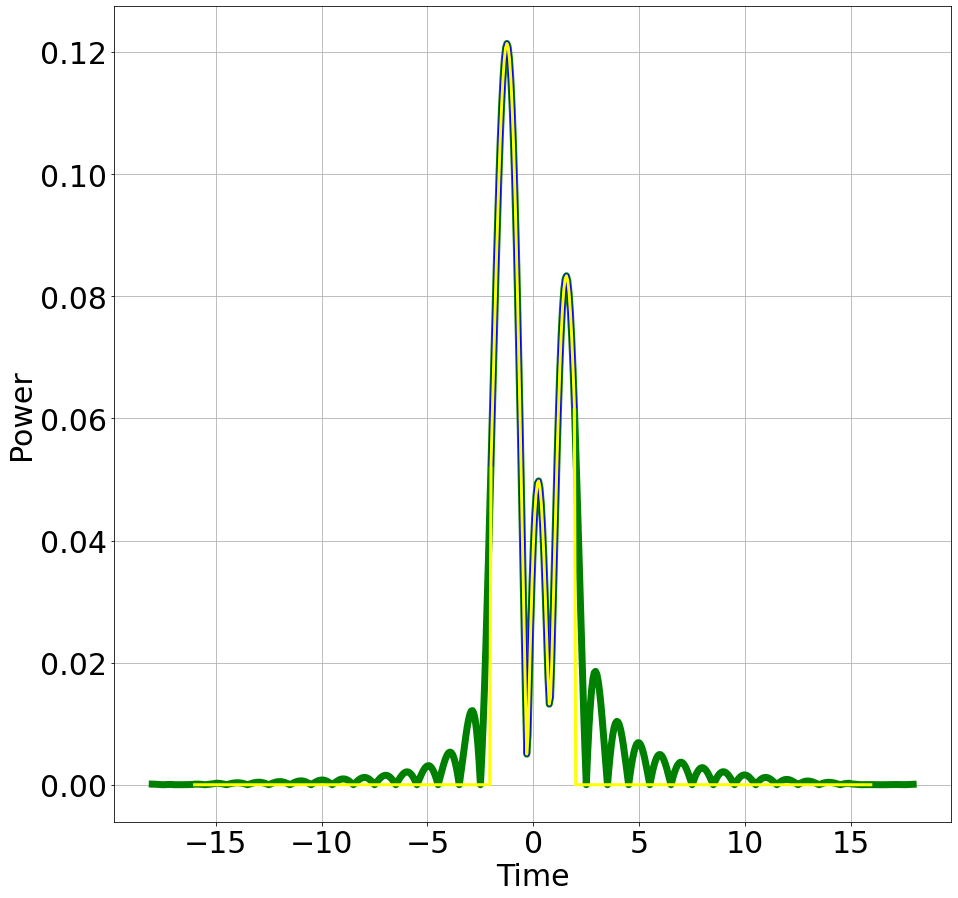

In [8]:
import signal_generation as sg
reload(sg)

mod_type = "16qam"
n_car = 1
t_symb = 1.

num_symbols = 4
np_symb = 16
n_lateral_symbols = 16
n_lateral = n_lateral_symbols * np_symb
p_ave = sg.dbm_to_nd(-4, t_symb=14.8)
roll_off = 0.1
dt = t_symb / np_symb

# generate bit sequence
n_bits = n_car * sg.get_n_bits(mod_type) * num_symbols
random.seed(0)
bits = random.getrandbits(n_bits)
data = "{0:b}".format(int(bits))
if len(data) < n_bits:
    data = ''.join('0' for add_bit in range(n_bits - len(data))) + data

# create signal and set power
signal_test = sg.get_wdm_signal(data, t_symb, np_symb, sg.rcos, [t_symb, roll_off],
                           n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral)
signal_test = sg.set_average_power(signal_test, dt, p_ave, len(signal_test) // 2 - n_lateral)

points_orig = np.array(sg.get_constellation_point(data, type=mod_type))
print(points_orig)

points_r = np.array(sg.get_points_wdm(signal_test, t_symb, np_symb, None, None, dw=1000., n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral))
print(points_r)

n_t = len(signal_test)
# t = np.array([(i - (n_t - 1) / 2) * dt for i in range(n_t)])
t = np.array([(i - n_t / 2) * dt for i in range(n_t)])

n_add = 0
num_symb_d = 0
num_symb_proc = 4
# num_symb_skip_shift = (num_symbols // 2 - num_symb_d - num_symb_proc // 2)  # initial shift from the left size
num_symb_skip_shift = 0
proc_iter = 0
step = num_symb_proc  # for how much symb we shift every step

num_symb_skip_base = num_symb_d + num_symb_skip_shift # desire skip to the proc interval. Have to be bigger that num_symb_d
num_symb_skip = num_symb_skip_base - num_symb_d + proc_iter * step
# num_symb_skip = 0

num_symb_total = 2 * num_symb_d + num_symb_proc  # total number of symbols to cut
# signal_cut, t_cut = get_sub_signal(q_prop, np_symb, t_symb, num_symb_total, num_symb_skip, n_add + n_lateral)
# signal_proc, t_proc = add_lateral_to_signal(signal_cut, slope, t_cut)
# print(len(signal_proc))

st_cut, tt_cut = get_sub_signal(signal_test, np_symb, t_symb, num_symb_total, num_symb_skip, n_add + n_lateral)
n_add_cut = (sg.round_power_of_2(4, len(st_cut)) - len(st_cut)) // 2
print(n_add_cut)
st_proc, tt_proc = add_lateral_to_signal(st_cut, slope, tt_cut, n_add_cut)

points_rc = np.array(sg.get_points_wdm(st_proc, t_symb, np_symb, None, None, n_carriers=n_car, mod_type=mod_type, n_lateral=n_add_cut))
print(points_rc)

points_rc_test = sg.get_nearest_constellation_points(sg.get_scale_coef(points_rc, mod_type) * points_rc, mod_type)
print(np.max(points_rc_test - points_orig))

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(t, np.absolute(signal_test), 'green', linewidth=7)
axs.plot(tt_cut, np.absolute(st_cut), 'blue', linewidth=5)
axs.plot(tt_proc, np.absolute(st_proc), 'yellow', linewidth=3)


# axs.set_xlim(-25, -23)
# axs.set_ylim(-25, -23)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)